<div class="alert alert-info">
<h1>Generalised Additive Model and Time series analysis</h1>
<h4>Environmental Statistics 7</h4>

Ikedichi E. Azuh/Carsten F. Dormann
</div>

In today's session, we'll explore Generalized Additive Models (GAMs) and their application in time series analysis, focusing on two key learning objectives. First, we'll learn how to run GAMs, a powerful statistical technique for modeling complex relationships between predictors and responses. Participants will gain hands-on experience in fitting GAMs to data and interpreting model results.

Next, we'll delve into the integration of GAMs into time series analysis. By incorporating GAMs, we can effectively capture non-linear trends and seasonality in time-dependent data, providing valuable insights into temporal patterns and dynamics. Through practical examples and demonstrations, attendees will learn how to apply GAMs to time series datasets, enabling them to extract meaningful information and make informed decisions in various fields such as finance, ecology, and economic s. 

There are two thing to learn today:
-  How to run a GAM.
-  How to use it in the context of time-series analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LogisticGAM, GAM, LinearGAM, s, te
import statsmodels.api as sm
import patsy
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod import families
links = families.links
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

## 1 Exercise 1: GAM for logistic/binomial regression
The Logistics regression from session 3 can be reproduced using LogisticGAM.

In [4]:
nes96 = pd.read_csv("nes96.csv")
nes96.head(7)

,popul,TVnews,selfLR,ClinLR,DoleLR,PID,age,educ,income,vote
0,0,7,extCon,extLib,Con,strRep,36,HS,$3Kminus,Dole
1,190,1,sliLib,sliLib,sliCon,weakDem,20,Coll,$3Kminus,Clinton
2,31,7,Lib,Lib,Con,weakDem,24,BAdeg,$3Kminus,Clinton
3,83,4,sliLib,Mod,sliCon,weakDem,28,BAdeg,$3Kminus,Clinton
4,640,7,sliCon,Con,Mod,strDem,68,BAdeg,$3Kminus,Clinton
5,110,3,sliLib,Mod,Con,weakDem,21,Coll,$3Kminus,Clinton
6,100,7,sliCon,Con,Mod,weakDem,77,Coll,$3Kminus,Clinton


We fitted the GLM as:

In [7]:
nes96['log_popul'] = np.log(nes96['popul'] + 1)

# We Recode to allow Dole take the value of 1.

nes96['vote_ENC'] = (nes96['vote'] == 'Dole').astype(int)  # 1 if 'Dole', 0 if 'Clinton'

expr = """vote_ENC ~ log_popul"""

y, X = patsy.dmatrices(expr, nes96, return_type='dataframe')


# Create and Fit the binomial regression model
fm = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Display the summary of the regression results
print(fm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               vote_ENC   No. Observations:                  944
Model:                            GLM   Df Residuals:                      942
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -627.40
Date:                Mon, 18 Mar 2024   Deviance:                       1254.8
Time:                        16:58:52   Pearson chi2:                     944.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02849
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1065      0.108      0.988      0.3

Now to refit with GAM:

In [12]:
# gam
X = nes96['log_popul']
y = nes96['vote_ENC']
gam_model = LogisticGAM(s(0), lam=1).fit(X, y)

# Display the summary
print(gam_model.summary())

# lam = 0: No regularization, the model can potentially overfit the data.
# lam > 0: Increasing regularization strength, which helps prevent overfitting.


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      9.8791
Link Function:                        LogitLink Log Likelihood:                                  -621.7927
Number of Samples:                          944 AIC:                                             1263.3435
                                                AICc:                                            1263.6208
                                                UBRE:                                               3.3467
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                     0.03
Feature Function                  Lam

C:\Users\Ikedichi_Azuh\AppData\Local\Temp\ipykernel_3536\1850304345.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_model.summary())


## 2 Exercise 2: Linear regression with temporal autocorrelation
In this analysis, we'll explore linear regression with temporal autocorrelation using atmospheric CO2-concentration data from the `locfit` package in R. By examining the temporal patterns in CO2 levels, we aim to understand how they relate to other variables of interest, shedding light on the dynamics of atmospheric carbon dioxide over time.

In [30]:
co2 = pd.read_csv("co2.csv")
co2.head()

,year,month,co2
0,1959,1,315.42
1,1959,2,316.32
2,1959,3,316.49
3,1959,4,317.56
4,1959,5,318.13


### 2.1 Plot and analyse CO$_2$-concentrations at Mauna Loa
For the analysis, first fit a linear model with polynomial terms for `year` and `month` and store residuals.

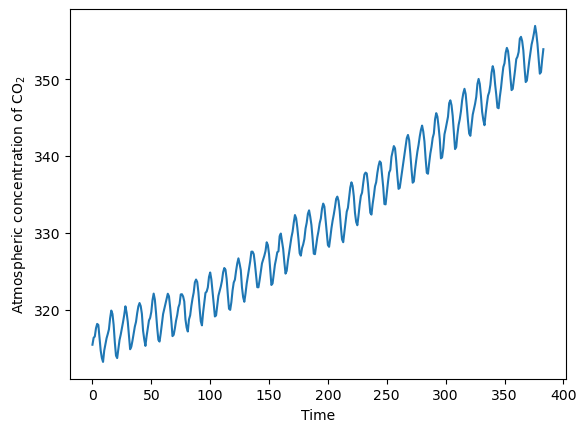

In [15]:
plt.plot(co2['co2'])
plt.xlabel('Time')
plt.ylabel('Atmospheric concentration of CO$_2$')
plt.show()


In [16]:
# Create polynomial features for 'year' and 'month'
co2['year_squared'] = co2['year'] ** 2
co2['year_cubed'] = co2['year'] ** 3
co2['month_squared'] = co2['month'] ** 2
co2['month_cubed'] = co2['month'] ** 3
co2['month_quartic'] = co2['month'] ** 4
co2['month_quintic'] = co2['month'] ** 5

X = co2[['year', 'year_squared', 'year_cubed', 'month', 'month_squared', 'month_cubed', 'month_quartic', 'month_quintic']]
X = sm.add_constant(X)
y = co2['co2']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

residuals = results.resid


                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.097e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:27:47   Log-Likelihood:                -270.02
No. Observations:                 384   AIC:                             556.0
Df Residuals:                     376   BIC:                             587.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0548      0.001     55.124

In [17]:
# similarly

formula = 'co2 ~ year + I(year**2) + I(year**3)+ month + I(month**2) + I(month**3) + I(month**4) + I(month**5)'

model = sm.OLS.from_formula(formula, data = co2)
results = model.fit()

print(results.summary())

residuals = results.resid

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.097e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:27:48   Log-Likelihood:                -270.02
No. Observations:                 384   AIC:                             556.0
Df Residuals:                     376   BIC:                             587.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0548      0.001     55.124

### 2.2 Visualise temporal autocorrelation in residuals
Plot both the autocorrelation function and the *partial* autocorrelation function.

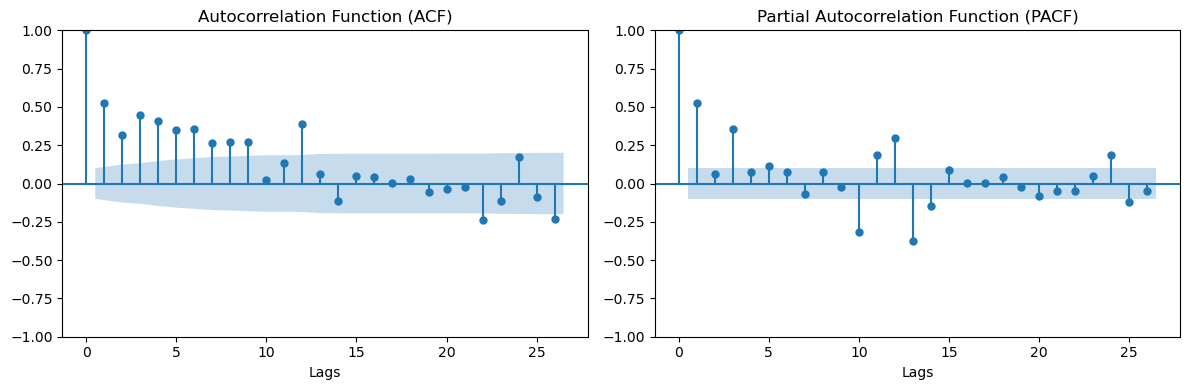

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(residuals, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lags')

# PACF
plot_pacf(residuals, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lags')

plt.tight_layout()
plt.show()


There seems to be a lag-1 autocorrelation (as visible in the PACF-plot).

### 2.3 Fit GAM to these data, using cyclic splines
Fit, and plot partial residual autocorrelation.

In [19]:
# s() spline terms
# f() factor terms
# te() tensor products or interaction
# n_splines: spline function on feature 1, with 12 basis functions


X = co2[['year', 'month']]
y = co2['co2']

gamco2 = GAM(s(0) + s(1, n_splines=12))
gamco2.fit(X, y)

print(gamco2.summary())


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.6119
Link Function:                     IdentityLink Log Likelihood:                                 -1070.9155
Number of Samples:                          384 AIC:                                             2183.0548
                                                AICc:                                            2185.5133
                                                GCV:                                                0.1305
                                                Scale:                                              0.1185
                                                Pseudo R-Squared:                                   0.9992
Feature Function                  Lam

C:\Users\Ikedichi_Azuh\AppData\Local\Temp\ipykernel_3536\674276708.py:13: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gamco2.summary())


In [20]:
# another way: using LinearGAM()
X = co2[['year', 'month']].values
y = co2['co2'].values

gam = LinearGAM(s(0) + s(1)).gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     30.4047
Link Function:                     IdentityLink Log Likelihood:                                 -1338.3352
Number of Samples:                          384 AIC:                                             2739.4799
                                                AICc:                                            2745.2687
                                                GCV:                                                0.1086
                                                Scale:                                              0.0932
                                                Pseudo R-Squared:                                   0.9994
Feature Function                  Lam

C:\Users\Ikedichi_Azuh\AppData\Local\Temp\ipykernel_3536\3100371606.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


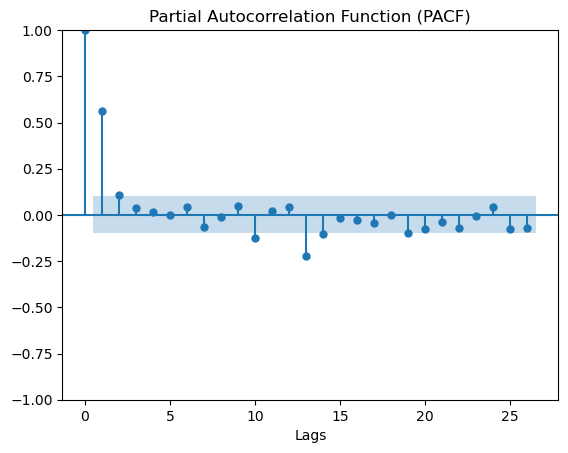

In [23]:
# PACF (model diagnostics)
resids_gamco2 = y - gamco2.predict(X)

plot_pacf(resids_gamco2)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.show()

It seems that the various patterns of autocorrelation in the linear model were caused by the relatively unflexible polynomial terms. The GAM is clearly more flexible and only has a lag-l temporal autocorrelation.

### 2.4 Augment the GAM with an AR1 term
This is possible with `mgcv` package in R with function gamm (for example: `gamm(co2 ~ s(year) + s(month, bs="cc", k=12), data=co2,
correlation=corAR1(form=~month|year))`) but currently GAM in python has no such function. In python AR, MA or ARMA can be fitted using the `ARIMA` function from the `statsmodels.tsa.arima.model` or `SARIMAX` function from the `statsmodels.tsa` library.


C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


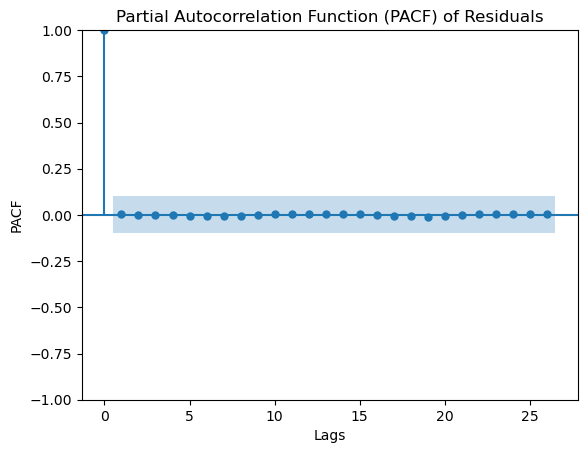

In [31]:
# AR(1) using SARIMAX
co2['date'] = pd.to_datetime(co2[['year', 'month']].assign(day=1))

# Set the date column as the index
co2.set_index('date', inplace=True)

model = sm.tsa.SARIMAX(co2['co2'], order=(1, 0, 0))  # AR(1) model
results = model.fit()

residuals = results.resid

plot_pacf(residuals)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Ikedichi_Azuh\anaconda3\envs\envstats2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


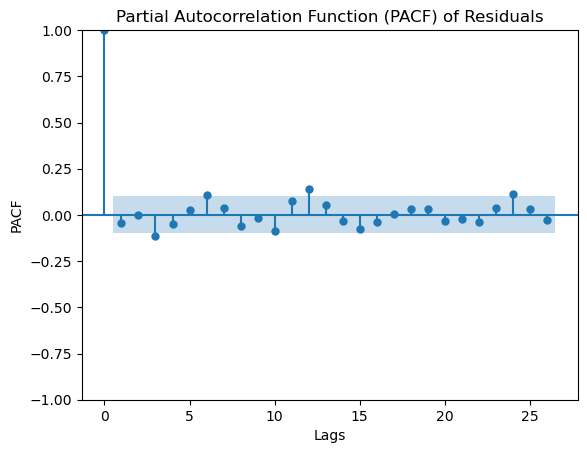

In [53]:
# ARMA(3,2) using ARIMA
import statsmodels
model = statsmodels.tsa.arima.model.ARIMA(co2['co2'], order=(3, 0, 2))
model_fit = model.fit()

residuals = model_fit.resid

plot_pacf(residuals)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

As we can see, the residuals are now free from temporal autocorrelation.


## 3.1  Exercise 3: Protva runoff analysis
Here, we analyze Protva runoff patterns as a function of interacting temperature and precipitation. By examining the relationship between these climatic factors and Protva runoff levels, we aim to better understand the hydrological dynamics of the region and their implications for water resource management.

In [35]:
# load data
spas = pd.read_csv('spas.csv')
spas['Date'] = pd.to_datetime(spas['Date'])
spas.head()

,Date,Q,Temp,Prec
0,1956-01-01,5.18,-6.46,0.453
1,1956-01-02,5.18,-11.41,0.825
2,1956-01-03,5.44,-10.74,0.260
3,1956-01-04,5.44,-8.05,0.397
4,1956-01-05,5.44,-11.73,0.102


Plot runoff on a log scale over time.

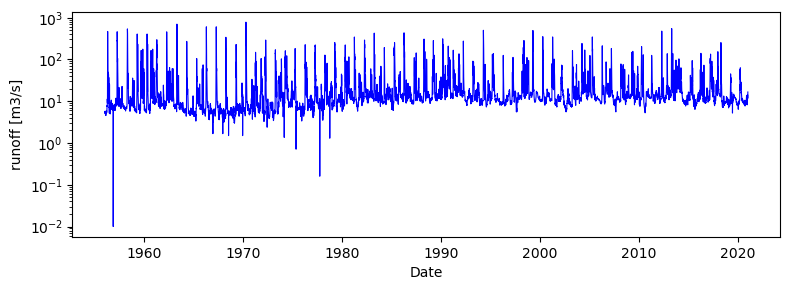

In [36]:
# plot
plt.figure(figsize=(8,3))
plt.plot(spas['Date'], spas['Q'], linestyle='-', color='blue', linewidth=0.8)
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('runoff [m3/s]')
plt.tight_layout()
plt.show()


The data point with a value below 0.1 seems to be unreliable and possibly should be set to NA.

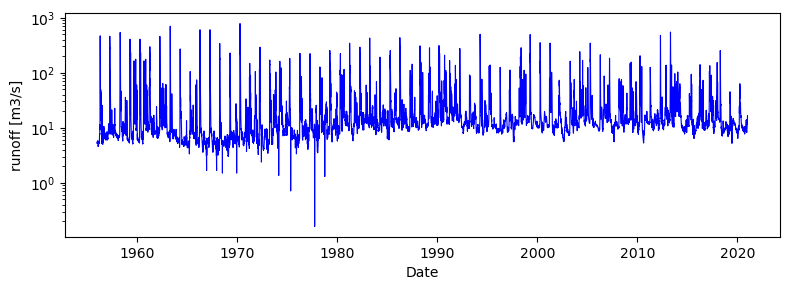

In [27]:
spas.loc[spas['Q'] < 0.1, 'Q'] = np.nan

plt.figure(figsize=(8,3))
plt.plot(spas['Date'], spas['Q'], linestyle='-', color='blue', linewidth=0.8)
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('runoff [m3/s]')
plt.tight_layout()
plt.show()


### 3.2 Analysis

In [28]:
fm = smf.ols(formula='np.log10(Q) ~ Prec * Temp + I(Prec**2) + I(Temp**2)', data=spas).fit()

print(fm.summary())


                            OLS Regression Results                            
Dep. Variable:            np.log10(Q)   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     543.4
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:31:05   Log-Likelihood:                -6354.7
No. Observations:               23741   AIC:                         1.272e+04
Df Residuals:                   23735   BIC:                         1.277e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1966      0.003    354.736   

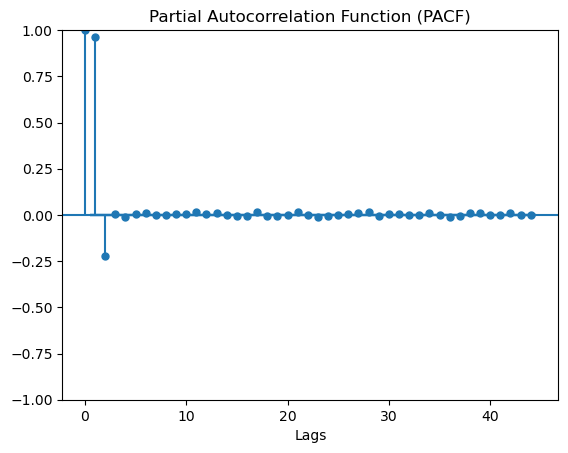

In [37]:
residuals = fm.resid

# PACF
plot_pacf(residuals)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.show()

Now we repeat the process using GAM

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     22.5076
Link Function:                     IdentityLink Log Likelihood:                                -91994.7405
Number of Samples:                        23742 AIC:                                           184036.4962
                                                AICc:                                          184036.5448
                                                GCV:                                                 0.094
                                                Scale:                                              0.0939
                                                Pseudo R-Squared:                                   0.1617
Feature Function                  Lam

C:\Users\Ikedichi_Azuh\AppData\Local\Temp\ipykernel_3536\2874403054.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(fgam.summary())


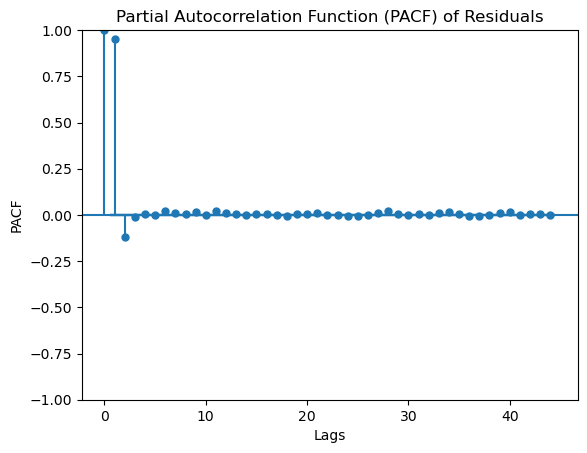

In [38]:
# In order for GAM to work, there must not be NANs or Inf
spas = spas.dropna(subset=['Q', 'Prec', 'Temp'])

X = np.column_stack([spas['Prec'], spas['Temp']])
y = np.log10(spas['Q'])

fgam = LinearGAM(te(0, 1)).fit(X, y)
print(fgam.summary())

predicted_values = fgam.predict(X)
res_fgam = y - predicted_values

plot_pacf(res_fgam)
plt.title('Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()


Woah, that’s a substantial autocorrelation. We can fit AR1 using ARIMA to deal with the little autocorrelation.